In [1]:
from analysis_tools.read_traj import ReadTraj
from analysis_tools.feature_creation import FrameToFeaturesPosition, TrajectoryToFeaturesPosition
from analysis_tools.feature_creation import FrameToFeaturesComposition, TrajectoryToFeaturesComposition
from analysis_tools.radial_distribution_function import RDF, PositionalSuceptibility
from analysis_tools.reservoir_sampler import ReservoirSampler
from analysis_tools.defect_analysis import DefectStats
from analysis_tools.pop2d import POP2D
import gc
from IPython.display import clear_output
import h5py

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
def DownSampleFrames(frames, frame_samples):
    return frames[0::max(len(frames)/frame_samples, 1)][0:frame_samples]

## Specify the conditions

In [5]:
from numpy import arange, array

In [ ]:
#VERSION FOR PAPER I
N_nn = 3200 #number of nearest neighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
nn_inc = 10 #1 (full in paper) #reduces the number of nearest neighbors to include as features
remove_types = []
shuffle_data = True
N_batch = 1
batches_per_frame = 1 

In [275]:
#TEST
N_nn = 29 #number of nearest neighbors for pca analysis
split = 1 #chunks the data up so it can be processed by the pca tool if really large
nn_inc = 1 #1 (full in paper) #reduces the number of nearest neighbors to include as features
remove_types = []
shuffle_data = True
N_batch = 1
batches_per_frame = 1 #10 #5

In [7]:
#specify what data to read in and process
traj_type = 'gsd'
file_data = [(arange(0.550, 0.690001, 0.005), '../hoomd_disks/trajectories_4000p', 400), 
             (arange(0.695, 0.820001, 0.005),'../hoomd_disks/trajectories_4000p_longer', 400)]

In [8]:
#actual data
etas = []
[etas.extend(etas_) for etas_, _, _ in file_data]
etas = array(etas)
color_ids = []
[color_ids.extend(len(data[0])*[count]) for count, data in zip(range(len(file_data)), file_data)]
color_ids = array(color_ids)

## Read in the data

In [9]:
from numpy import array_split
from sklearn.decomposition import IncrementalPCA

In [10]:
corrected_features = []
incpca_ig = IncrementalPCA(n_components=None, whiten=True) 
force_randomize = False

#loop over data sets 
for phase in ['fit_whitener', 'correct_features']:
    raw_features = []
    
    for etas_, file_base, frame_samples in file_data:

        for eta in etas_:
            print 'COMPUTATION DETAILS'
            print 'file_base = {}'.format(file_base)
            print 'eta = {}'.format(eta)

            #read in data and randomize positions if performing ideal gas correction
            filename = "{}/trajectory_{:.4f}.{}".format(file_base, eta, traj_type)
            randomize = (phase == 'fit_whitener') or force_randomize
            frames = ReadTraj(filename, traj_type, shuffle_data, randomize, remove_types)

            #control the number of total frames to analyze
            len_frames_init = len(frames)
            frames = DownSampleFrames(frames, frame_samples)
            print 'using {} frames of {} total'.format(len(frames), len_frames_init)
            
            raw_features.extend(TrajectoryToFeaturesPosition(frames, 
                                                             N_nn=N_nn,  
                                                             nn_inc=nn_inc,
                                                             N_batch=N_batch, 
                                                             batches_per_frame=batches_per_frame))
    if phase == 'fit_whitener':
        print 'Fitting the whitener\n'
        incpca_ig.fit(raw_features)
    else:
        print 'Correcting features\n'
        corrected_features = incpca_ig.transform(raw_features)
            
            

COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.55
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.555
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.56
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.565
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.57
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.575
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.58
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.585
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.59
using 400 frames of 1000 total
COMPUTATION DETAILS
file

using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.645
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.65
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.655
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.66
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.665
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.67
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.675
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.68
using 400 frames of 1000 total
COMPUTATION DETAILS
file_base = ../hoomd_disks/trajectories_4000p
eta = 0.685
using 400 frames of 100

# Autoencoding

In [11]:
from analysis_tools.autoencoder import AutoEncoder
from sklearn.model_selection import train_test_split

Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [12]:
dim = corrected_features.shape[1]
print "Dimensionality: {}".format(dim)

Dimensionality: 320


### Train and test sets

In [13]:
corrected_features_train, corrected_features_test = train_test_split(corrected_features, test_size=0.25, random_state=42)

### Build and train the model

In [76]:
from keras.callbacks import ModelCheckpoint
from numpy import savetxt

In [81]:
model = AutoEncoder(dim=dim, encode_dim=1, 
                    initial_growth=0.25, shrink=0.65,
                    activation='linear')#, kernel_initializer='lecun_normal')

In [332]:
model = AutoEncoder(dim=dim, encode_dim=1, 
                    initial_growth=0.25, shrink=0.25,
                    activation='linear')

In [360]:
print model.layer_dims

[543, 407, 305, 228, 171, 128, 96, 72, 54, 40, 30, 22, 16, 12, 9, 6, 4, 3, 2, 1, 2, 3, 4, 6, 9, 12, 16, 22, 30, 40, 54, 72, 96, 128, 171, 228, 305, 407, 543, 435]


In [82]:
model.Compile(optimizer='adamax', loss='mean_squared_error')

In [83]:
checkpointer = ModelCheckpoint(filepath='./model/weights_linear.hdf5', verbose=1, save_best_only=True)

In [84]:
history_raw = model.Fit(corrected_features_train, corrected_features_test,
                epochs=100, batch_size=500, shuffle=True, callbacks=[checkpointer])

Train on 16500 samples, validate on 5500 samples
Epoch 1/100
16500/16500 [==============================] - 1s - loss: 1.1901 - val_loss: 0.8831
Epoch 2/100
16500/16500 [==============================] - 1s - loss: 0.8488 - val_loss: 0.8407
Epoch 3/100
16500/16500 [==============================] - 1s - loss: 0.8371 - val_loss: 0.8375
Epoch 4/100
16500/16500 [==============================] - 1s - loss: 0.8351 - val_loss: 0.8361
Epoch 5/100
16500/16500 [==============================] - 1s - loss: 0.8340 - val_loss: 0.8353
Epoch 6/100
16500/16500 [==============================] - 1s - loss: 0.8333 - val_loss: 0.8346
Epoch 7/100
16500/16500 [==============================] - 1s - loss: 0.8327 - val_loss: 0.8342
Epoch 8/100
16500/16500 [==============================] - 1s - loss: 0.8323 - val_loss: 0.8339
Epoch 9/100
16500/16500 [==============================] - 1s - loss: 0.8321 - val_loss: 0.8336
Epoch 10/100
16500/16500 [==============================] - 1s - loss: 0.8318 - val_los

16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8334
Epoch 36/100
16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8333
Epoch 37/100
16500/16500 [==============================] - 0s - loss: 0.8317 - val_loss: 0.8333
Epoch 38/100
16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8333
Epoch 39/100
16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8333
Epoch 40/100
16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8334
Epoch 41/100
16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8334
Epoch 42/100
16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8333
Epoch 43/100
16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8334
Epoch 44/100
16500/16500 [==============================] - 0s - loss: 0.8317 - val_loss: 0.8336
Epoch 45/100
16500/16500 [=================

16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8334
Epoch 76/100
16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8333
Epoch 77/100
16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8332
Epoch 78/100
16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8333
Epoch 79/100
16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8332
Epoch 80/100
16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8334
Epoch 81/100
16500/16500 [==============================] - 0s - loss: 0.8317 - val_loss: 0.8334
Epoch 82/100
16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8334
Epoch 83/100
16500/16500 [==============================] - 0s - loss: 0.8317 - val_loss: 0.8333
Epoch 84/100
16500/16500 [==============================] - 0s - loss: 0.8316 - val_loss: 0.8334
Epoch 85/100
16500/16500 [=================

In [78]:
#savetxt('./model/val_loss_linear.txt', history_raw.history['val_loss'])

### Check out the results 

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
%matplotlib inline 

(0, 1000)

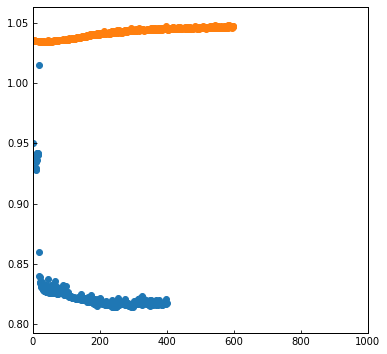

In [368]:
plt.scatter(range(len(history_raw.history['val_loss'])), history_raw.history['val_loss'])
#plt.ylim(0.8,0.86)
plt.xlim(0,1000)

In [114]:
model.Summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 320)               0         
_________________________________________________________________
dense_157 (Dense)            (None, 400)               128400    
_________________________________________________________________
dense_158 (Dense)            (None, 260)               104260    
_________________________________________________________________
dense_159 (Dense)            (None, 169)               44109     
_________________________________________________________________
dense_160 (Dense)            (None, 109)               18530     
_________________________________________________________________
dense_161 (Dense)            (None, 70)                7700      
_________________________________________________________________
dense_162 (Dense)            (None, 45)                3195      
__________

In [369]:
encoded_data = model.Predict(corrected_features)

In [370]:
from numpy import mean

In [371]:
OP = []
for i in range(len(etas)):
    OP.append(mean(encoded_data[:,0][i*400:i*400+400]))

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  


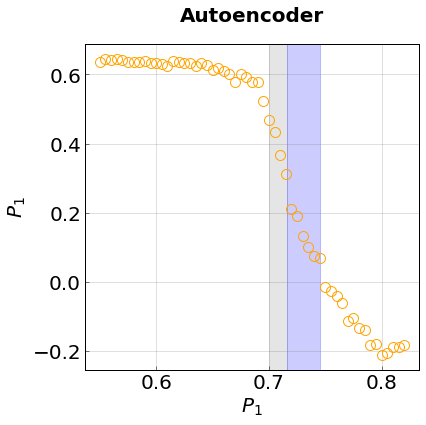

In [372]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.745, alpha=0.2, color='blue')

plt.plot(etas, -array(OP), marker='o', linewidth=0.0, markersize=10, color = 'orange', alpha=1.0, markerfacecolor='None') 


#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0,0.3)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  


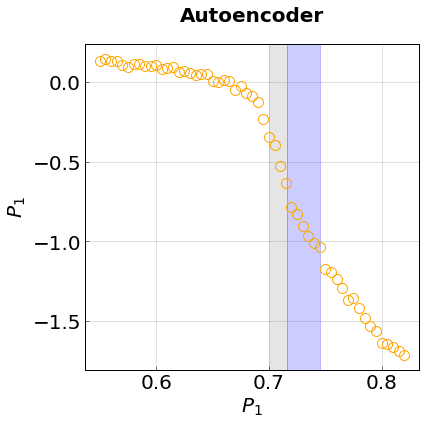

In [340]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.745, alpha=0.2, color='blue')

plt.plot(etas, -array(OP), marker='o', linewidth=0.0, markersize=10, color = 'orange', alpha=1.0, markerfacecolor='None') 


#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0,0.3)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  


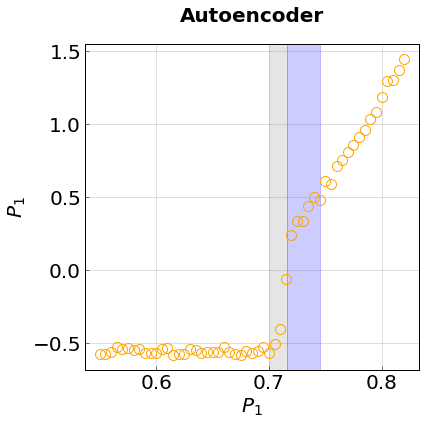

In [47]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'black', 'red']

#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.745, alpha=0.2, color='blue')

plt.plot(etas, array(OP), marker='o', linewidth=0.0, markersize=10, color = 'orange', alpha=1.0, markerfacecolor='None') 


#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0,0.3)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

## Check out the 10 iterations

In [87]:
from numpy import mean, loadtxt

In [19]:
model = AutoEncoder(dim=dim, encode_dim=1, 
                    initial_growth=0.25, shrink=0.65,
                    activation='selu', kernel_initializer='lecun_normal')

In [115]:
model.Summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 320)               0         
_________________________________________________________________
dense_157 (Dense)            (None, 400)               128400    
_________________________________________________________________
dense_158 (Dense)            (None, 260)               104260    
_________________________________________________________________
dense_159 (Dense)            (None, 169)               44109     
_________________________________________________________________
dense_160 (Dense)            (None, 109)               18530     
_________________________________________________________________
dense_161 (Dense)            (None, 70)                7700      
_________________________________________________________________
dense_162 (Dense)            (None, 45)                3195      
__________

In [90]:
OP_set = []
error_set = []
for i in range(10):
    print i
    model.autoencoder.load_weights('./model/weights_{}.hdf5'.format(i))
    model.Compile(optimizer='adamax', loss='mean_squared_error')
    encoded_data = model.Predict(corrected_features)
    OP = []
    for j in range(len(etas)):
        OP.append(mean(encoded_data[:,0][j*400:j*400+400]))
    OP_set.append(OP)
    error_set.append(loadtxt('./model/val_loss_{}.txt'.format(i)))

print 'linear'
model.autoencoder.load_weights('./model/weights_linear.hdf5'.format(i))
model.Compile(optimizer='adamax', loss='mean_squared_error')
encoded_data = model.Predict(corrected_features)
OP_linear = []
for i in range(len(etas)):
    OP_linear.append(mean(encoded_data[:,0][i*400:i*400+400]))
error_linear = loadtxt('./model/val_loss_linear.txt')

0
1
2
3
4
5
6
7
8
9
linear


/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  app.launch_new_instance()


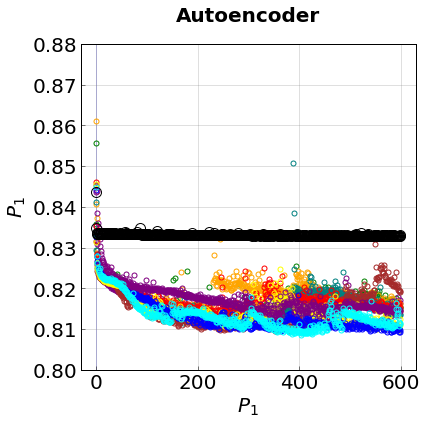

In [106]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'red', 'brown', 'yellow', 'blue', 'purple', 'cyan']

#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.745, alpha=0.2, color='blue')

for i in range(len(OP_set)):
    plt.plot(range(len(error_set[i])), error_set[i], marker='o', linewidth=0.0, markersize=5, color = colors[i], alpha=1.0, markerfacecolor='None')
    
plt.plot(range(len(error_linear)), error_linear, marker='o', linewidth=0.0, markersize=10, color = 'black', alpha=2.0, markerfacecolor='None') 

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
plt.ylim(0.8,0.88)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

/home/ryanj/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


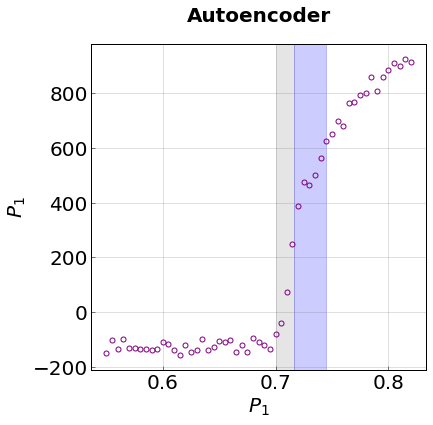

In [113]:
#plot the principal components
colors = 200*['green', 'purple', 'orange', 'teal', 'red', 'brown', 'yellow', 'blue', 'magenta', 'cyan']

#highlight the transition region if found
plt.axvspan(0.700, 0.716, alpha=0.2, color='grey')
plt.axvspan(0.716, 0.745, alpha=0.2, color='blue')

#for i in range(len(OP_set)):
    #plt.plot(etas, array(OP_set[i]), marker='o', linewidth=0.0, markersize=5, color = colors[i], alpha=1.0, markerfacecolor='None')
    
#plt.plot(etas, OP_linear, marker='o', linewidth=0.0, markersize=10, color = 'black', alpha=2.0, markerfacecolor='None') 
index = 1
plt.plot(etas, array(OP_set[index]), marker='o', linewidth=0.0, markersize=5, color = colors[index], alpha=1.0, markerfacecolor='None')

#backround grid details
axes = plt.gca()
axes.grid(b = True, which = 'both', axis = 'both', color = 'gray', linestyle = '-', alpha = 0.5, linewidth = 0.5) 
axes.set_axis_bgcolor('white')  

#font scpecifications
title_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'heavy','size': 20}
axis_label_font = {'family' : 'arial', 'color'  : 'black', 'weight' : 'normal','size': 20}                                                   

#figure size and tick style
plt.rcParams["figure.figsize"] = [6,6]
plt.rc('axes',edgecolor='black',linewidth=1)
plt.tick_params(which='both', axis='both', color='black', length=4, width=0.5)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

#plt.yscale('log')
#plt.ylim(0,0.3)

plt.xlabel(r'$P_{1}$', y=3, fontsize=20, fontdict = axis_label_font)
plt.ylabel(r'$P_{1}$', fontsize=20, fontdict = axis_label_font)

#title and axis labels
plt.tick_params(axis='both', labelsize=20)
plt.title('Autoencoder', y=1.05, fontdict = title_font)

plt.show()

In [113]:
from copy import deepcopy
from numpy import concatenate, log, power, rint, sqrt, sum, unique, repeat, arccos, dot, transpose, append, cos, sin, hstack, maximum, minimum, pi, array, mean
from numpy.linalg import norm
from numpy.random import shuffle, choice
from sklearn import preprocessing
import warnings

#this generates NN features for the PCA analysis (or some other machine learning method as well)
def FrameToFeaturesPosition(frame, N_nn, nn_inc, N_batch, batches_per_frame):
    #extract some relevant frames level details
    coords = deepcopy(frame['coords'])
    D = float(frame['D'])
    N = float(len(coords))
    V = power(frame['L'], D)
    normalizing_distance = power(V/N, 1.0/D)
    
    #loop over the batches
    aggregated_frame_features = []
    for i in range(batches_per_frame):
        coords_batch = coords[choice(int(N), N_batch, replace=False)]

        #loop over the particles
        frame_features = []
        for particle in coords_batch:
            #nearest neighbor coordinate wrapping
            Rpj_v = particle - coords
            Rpj_v = Rpj_v - rint(Rpj_v/frame['L'])*frame['L']
            Rpj = (sqrt(sum(power(Rpj_v, 2.0), axis=1)))     #tagged particles NN

            #sorting by the distance to enable the discovery of positional order
            sorter = Rpj.argsort()
            Rpj_v = Rpj_v[sorter[::1]][1:N_nn+1]
            Rpj = Rpj[sorter[::1]][1:N_nn+1]
            
            #calculate sorted distances between the NNs
            features = deepcopy(Rpj)
            for i in range(len(Rpj_v)-1):
                nn_Rij_v = Rpj_v[i] - Rpj_v[i+1:]
                nn_Rij_v = nn_Rij_v - rint(nn_Rij_v/frame['L'])*frame['L']
                nn_Rij = (sqrt(sum(power(nn_Rij_v, 2.0), axis=1)))
                features = concatenate((features, nn_Rij), axis=0)
 
            #create features that correspond to probe particles and their nearest neighbors
            frame_features.append(features/normalizing_distance)

        #sort by the first nearest neighbor to again provide some positional basis on which to learn correlations
        #frame_features = array(frame_features)
        #sorter = frame_features[:,5].argsort()
        #frame_features = frame_features[sorter]
        
        #TEST
        #sorter = mean(frame_features, axis=1).argsort()
        #frame_features = frame_features[sorter]
        
        shuffle(frame_features)
        #TEST
        
        aggregated_frame_features.append(array(frame_features).flatten())

    return array(aggregated_frame_features)

#this converts an entire trajectory into features
def TrajectoryToFeaturesPosition(frames, N_nn, nn_inc, N_batch, batches_per_frame):
    #print filename
    features = []
    for frame in frames: 
        aggregated_frame_features = FrameToFeaturesPosition(frame, N_nn, nn_inc, N_batch, batches_per_frame)
        for frame_features in aggregated_frame_features:
            features.append(frame_features)
    return array(features)

In [269]:
len(corrected_features)

44000

### Build a radial basis function network

In [131]:
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

In [140]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.initializers import Constant
import numpy as np

In [496]:
class RadiallyPositionedBasis(Layer):
    
    def __init__(self, output_dim, rcs, init_sigma=0.1, **kwargs):
        #self consistency check to ensure that the number of rcs equals 
        #the expected number of output dimensions
        self.rcs_dim = len(rcs)
        assert output_dim == self.rcs_dim
        
        self.output_dim = output_dim
        self.rcs = K.variable(value=rcs)
        self.init_sigma = init_sigma
        super(RadiallyPositionedBasis, self).__init__(**kwargs)

    def build(self, input_shape):
        #check that we are only using only scalar quantities 
        assert input_shape[1] == 1
        
        #create the optimizable standard deviations for the gaussian basis functions
        self.sigmas = self.add_weight(name='sigmas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(value=self.init_sigma),
                                     trainable=True)
        super(RadiallyPositionedBasis, self).build(input_shape)  

    def call(self, x):
        X = K.repeat_elements(x, self.rcs_dim, axis=1)
        return K.exp(-(self.rcs-X)**2.0)/self.sigmas

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RadiallyPositionedBasis, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [572]:
from keras.layers import Input, Dense
from keras.models import Model

In [607]:
rcs = arange(0.0, 5.0001, 1.0)
print rcs

r = Input(shape=(1,))
signal = RadiallyPositionedBasis(len(rcs), rcs, init_sigma=0.01)(r)
signal = Dense(len(rcs), activation='elu')(signal)
Fr = Dense(1, activation='linear')(signal)

# this model maps an input to its reconstruction
model = Model(r, Fr)

[ 0.  1.  2.  3.  4.  5.]


In [608]:
from numpy import cos, transpose

In [609]:
r_train = transpose([arange(0.0,5.0,0.0001)])
Fr_train = cos(r_train)

In [610]:
model.compile(optimizer='adamax', loss='mean_squared_error')

In [611]:
model.fit(r_train, Fr_train,
                epochs=50,
                batch_size=20,
                shuffle=True)

Epoch 1/50
50000/50000 [==============================] - 0s - loss: 6.5522     
Epoch 2/50
50000/50000 [==============================] - 0s - loss: 0.1371     
Epoch 3/50
50000/50000 [==============================] - 0s - loss: 0.0227     
Epoch 4/50
50000/50000 [==============================] - 0s - loss: 0.0027     
Epoch 5/50
50000/50000 [==============================] - 0s - loss: 8.8110e-04     
Epoch 6/50
50000/50000 [==============================] - 0s - loss: 3.0172e-04     
Epoch 7/50
50000/50000 [==============================] - 0s - loss: 1.5949e-04     
Epoch 8/50
50000/50000 [==============================] - 0s - loss: 9.3706e-05     
Epoch 9/50
50000/50000 [==============================] - 0s - loss: 6.1320e-05     
Epoch 10/50
50000/50000 [==============================] - 0s - loss: 5.2069e-05     
Epoch 11/50
50000/50000 [==============================] - 0s - loss: 4.3518e-05     
Epoch 12/50
50000/50000 [==============================] - 0s - loss: 3.7967e-0

In [606]:
model.fit(r_train, Fr_train,
                epochs=50,
                batch_size=20,
                shuffle=True)

Epoch 1/50
50000/50000 [==============================] - 0s - loss: 66.8001     
Epoch 2/50
50000/50000 [==============================] - 0s - loss: 2.3889     
Epoch 3/50
50000/50000 [==============================] - 0s - loss: 0.0704     - ETA: 0s - los
Epoch 4/50
50000/50000 [==============================] - 0s - loss: 1.2115e-04     
Epoch 5/50
50000/50000 [==============================] - 0s - loss: 1.1211e-04     
Epoch 6/50
50000/50000 [==============================] - 0s - loss: 9.3888e-05     
Epoch 7/50
50000/50000 [==============================] - 0s - loss: 7.1616e-05     
Epoch 8/50
50000/50000 [==============================] - 0s - loss: 5.7545e-05     
Epoch 9/50
50000/50000 [==============================] - 0s - loss: 4.7433e-05     
Epoch 10/50
50000/50000 [==============================] - 0s - loss: 4.0514e-05     
Epoch 11/50
50000/50000 [==============================] - 0s - loss: 3.6632e-05     
Epoch 12/50
50000/50000 [==============================] - 

In [612]:
Fr_predict = model.predict(r_train)

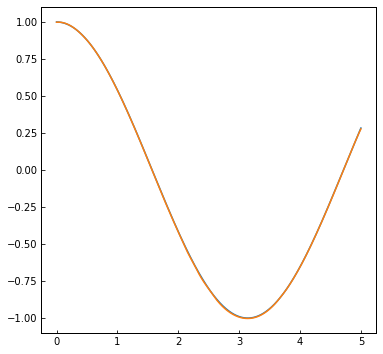

In [613]:
plt.plot(r_train, Fr_train)
plt.plot(r_train, Fr_predict)